In [15]:
import cv2
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import os
from PIL import Image
from PIL.ExifTags import TAGS
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter

from py2neo import Graph, Node


website = 'fenninggroupnas.ucsd.edu'
port = 7687

graph = Graph(f"bolt://{website}:{port}", auth=("neo4j", "magenta-traffic-powder-anatomy-basket-8461")) # magenta-etc is the passphrase


data_folder = 'images_and_data/'

# Colormetrics Guide
With this guide, you will be able to: 
1. Generate the colormetrics csv for every sample against time
2. Push the colormetrics data to the graph database

## Choosing Baseline Image
This approach employs a baseline image that the algorithm uses to crop all the images for analysis. 

First, download the first image from a batch of images, crop it to an appropriate size and frame, and save it as 'baseline.jpg'. 

## 1. Find warping parameters
The goal here is to set warping parameters that enable modifying a cropped image to a bird's eye view. The variables you need to modify are: `pts1`, `pts2`, and `magnitude`.

An example of a successful warp is shown below: 

![warped_example](warping_example.png)

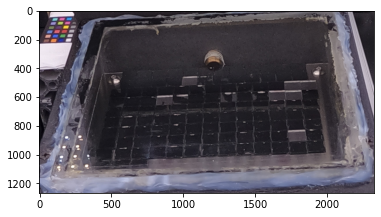

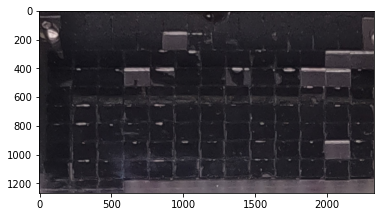

In [2]:
###########################################################################
###########################################################################
###########################################################################

# Define the points in the original image (corners of the original image)
pts1 = np.float32([[500, 410], [1900, 340], [350, 1100], [2000, 1050]])  # top left, top right, bottom left, bottom right
# Define the magnitude of the transformation (e.g., 0.05 for a 5% stretch at the top)
magnitude = 0.01

def apply_perspective_transform(frame, M, cols, rows):
    return cv2.warpPerspective(frame, M, (cols, rows))

baseline = plt.imread(data_folder + 'baseline_template.jpg')
rows, cols, _ = baseline.shape

# Define where those points will be in the transformed image (stretching the top)
pts2 = np.float32([[0, -rows * magnitude], [cols - 1, -rows * magnitude], [0, rows - 1], [cols - 1, rows - 1]])

# Compute the perspective transformation matrix
M = cv2.getPerspectiveTransform(pts1, pts2)


############################################################
##############################################################
##############################################################
# Apply the transformation to see what it looks like
transformed_image = apply_perspective_transform(baseline, M, cols, rows)

# Display the original image
plt.imshow(baseline)
plt.show()

# Display the transformed image
plt.imshow(transformed_image)
plt.show()

## 2. Setting sample labels and center points

`center_points_0` is a variable that makes a grid of coordinates that correspond to the center of each sample.
<br>
`sample_names_0` is a variable that produces a numerical label for each sample. For eg. `sample0, sample1, sample2...`

The main variables to change here will be the `n_rows`, `n_cols`, and the integers in the for-loop assigning the center_points. 

In [3]:
n_rows, n_cols = 10, 13 # as there are 10 rows and 13 columns of samples in the this case
center_points_0 = np.full((10, 13), None, dtype=object)
sample_names_0 = np.arange(-1,129).reshape(n_rows, n_cols)

Next is the trickiest part, you'll have to modify the numbers in the first for-loop. This is for setting the coordinates in the `center_points_0` variable.
<br>
Note: `rows` and `cols` correspond to the coordinates in the grid that you see in the image printed out below, and ARE NOT THE SAME AS `n_rows` and `n_cols`.

Lastly, you might have to modify the `window_size`. The smaller the `window_size`, the smaller the area enclosed by the '*' markers in red for each sample.
<br>
A large `window_size` will mean a more accurate colormetrics result, just make sure it does not cover area in the adjacent samples

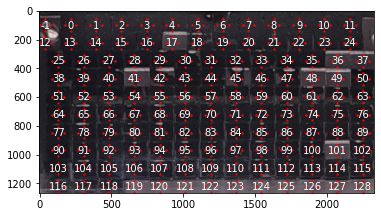

In [4]:
####################################################################
####################################################################
####################################################################

for i, y in enumerate(np.linspace(0+100,rows-rows//12 + 60,10)): 
    for j, x in enumerate(np.linspace(100, cols-cols//21, 13)):
        if i == 0 or i == 1:
            center_points_0[i,j] = (int(x)- 60,int(y))
        else: center_points_0[i,j] = (int(x) + 30,int(y))
            
for i in range(center_points_0.shape[0]):
    for j in range(center_points_0.shape[1]):
        x, y = center_points_0[i, j]
        sample_name = sample_names_0[i, j]
        window_size = 40


####################################################################
####################################################################
####################################################################
        # Annotate the image
        plt.scatter(x - window_size, y, color = 'red', s = 2)
        plt.scatter(x + window_size, y, color = 'red', s = 2)
        plt.scatter(x, y - window_size, color = 'red', s = 2)
        plt.scatter(x, y + window_size, marker='*', color = 'red', s = 2)
        plt.text(x, y, str(sample_name), color='white', fontsize=10, ha='center', va='center')

plt.imshow(transformed_image)

In [16]:
def rgb_to_cmyk(rgb):
    r, g, b = rgb[...,0], rgb[...,1], rgb[...,2]
    k = 1 - np.max(rgb, axis=-1)
    c = (1-r-k)/(1-k)
    m = (1-g-k)/(1-k)
    y = (1-b-k)/(1-k)
    return np.dstack([c, m, y, k])


def calculate_K_mean(vm):
    K_means = []
    for frame in range(vm.shape[0]):
        # Convert the frame to CMYK
        cmyk_image = rgb_to_cmyk(vm[frame, :, :, :]/255)
        
        # Extract the K channel
        K_channel = cmyk_image[:,:,3]
        
        # Calculate the 2.5th and 97.5th percentiles (95% CI)
        ci_low, ci_high = np.percentile(K_channel, [2.5, 97.5])
        
        # Mask the values outside the CI
        masked_K_channel = np.ma.masked_outside(K_channel, ci_low, ci_high)
        
        # Calculate the mean of the values within the CI
        K_mean = np.ma.mean(masked_K_channel)
        
        K_means.append(K_mean)
        
    return K_means


def apply_perspective_transform(frame, M, cols, rows):
    return cv2.warpPerspective(frame, M, (cols, rows))


def get_image_creation_date(image_path):
    try:
        with Image.open(image_path) as img:
            exif_data = img._getexif()
            if exif_data is not None:
                for tag, value in exif_data.items():
                    tag_name = TAGS.get(tag, tag)
                    if tag_name == 'DateTimeOriginal':
                        return value
    except Exception as e:
        print(f"Error reading EXIF data for {image_path}: {e}")
    return None

def crop_image(img, crop_params):
    x0, x1 = crop_params[0]
    y0, y1 = crop_params[1]
    return img[x0:x1, y0:y1]

def create_video_matrix(slice_dict, fids):
    
    # first_image = cv2.imread(fids_0[folder_name][0][0])
    # height, width, channels = first_image.shape

    # # Initialize the video matrix
    num_frames = len(fids)
    video_matrix = None
    
    if 'latest_template.jpg' in os.listdir():
        prev_template = cv2.imread('latest_template.jpg', 0)
    else:
        prev_template = cv2.imread(data_folder + 'baseline_template.jpg', 0)
        
    w, h = prev_template.shape[::-1]
    
    # Read each image, crop it, and populate the video matrix
    for i, info in enumerate(tqdm(fids,desc = f'Creating Video Matrix', leave = False)):
        
        image_path = info[0]
            
        frame = cv2.imread(image_path, 0)

        result = cv2.matchTemplate(frame, prev_template, cv2.TM_SQDIFF_NORMED)

        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        bottom_right = (min_loc[0] + w, min_loc[1] + h)

        crop_params = ((min_loc[1],min_loc[1]+h),(min_loc[0],min_loc[0]+w))

        prev_template = crop_image(frame, crop_params)
  
        frame = cv2.imread(image_path)

        frame = crop_image(frame, crop_params)
        
        height, width, channels = frame.shape
        if video_matrix is None:
            video_matrix = np.zeros((num_frames, height, width, channels), dtype=np.uint8)

        video_matrix[i] = frame
        
        if i + 1 == num_frames:
            cv2.imwrite('latest_template.jpg', prev_template)

    return video_matrix

def transform_vm(video_matrix):

    ####### REPLACE THIS BLOCK WITH CODE FROM 1 ############
    ########################################################
    ########################################################
    # Define the points in the original image (corners of the original image)
    transformed = np.zeros_like(video_matrix)
    rows, cols = video_matrix.shape[1:3]
    pts1 = np.float32([[500, 410], [1900, 340], [350, 1100], [2000, 1050]])  # top left, top right, bottom left, bottom right
    # Define the magnitude of the transformation (e.g., 0.05 for a 5% stretch at the top)
    magnitude = 0.01

    # Define where those points will be in the transformed image (stretching the top)
    pts2 = np.float32([[0, -rows * magnitude], [cols - 1, -rows * magnitude], [0, rows - 1], [cols - 1, rows - 1]])

    # Compute the perspective transformation matrix
    M = cv2.getPerspectiveTransform(pts1, pts2)
    ##########################################################
    #########################################################
    ########################################################

    # If the transformed image looks good, uncomment the following lines to apply the transformation to the whole video_matrix
    for i in range(video_matrix.shape[0]):
        transformed[i, :, :, :] = apply_perspective_transform(video_matrix[i, :, :, :], M, cols, rows)
    
    return transformed

def process_pictures(image_file_path, b_id='None'):
    full_df = None
    creation_time = []
    image_folder_0 = image_file_path
    go_pro_folders = os.listdir(image_folder_0)[::-1]
    go_pro_folders = np.sort(np.array(go_pro_folders))
    fids_0 = {}
    
    for folder in go_pro_folders:
        if folder not in fids_0:
            fids_0[folder] = []
        folder_path = os.path.join(image_folder_0, folder)
        images = np.array(os.listdir(folder_path))
        images = np.sort(images)
        for image in images:
            if 'control' not in image and '_rgb' not in image and 'ipynb' not in image:
                image_path = os.path.join(folder_path, image)
                creation_time = get_image_creation_date(image_path)
                fids_0[folder].append((image_path, creation_time))
                
    for i in fids_0.keys():
        all_frames = []
        all_frames.extend(fids_0[i])
            
        slice_dict = {}

        rows, cols = (1266, 2328) ################## replace this wth the rows and cols from earlier

        ###################### REPLACE WITH CODE FROM 2 ####################
        ####################################################################
        ####################################################################
        
        
        center_points_0 = np.full((10, 13), None, dtype=object)
        sample_names_0 = np.arange(-1,129).reshape(10,13)
        sample_names_0.shape
        for i, y in enumerate(np.linspace(0+100,rows-rows//12 + 60,10)):
            for j, x in enumerate(np.linspace(100, cols-cols//21, 13)):
                if i == 0 or i == 1:
                    center_points_0[i,j] = (int(x)- 60,int(y))
                else: center_points_0[i,j] = (int(x) + 30,int(y))
        
        window_size = 40
        ####################################################################
        ####################################################################
        ####################################################################
        samples_to_ignore = [17,22,38,39] ########## check 2 and write the list of samples that correspond to empty spaces
        used_sample_names = []
        for s in sample_names_0.flatten():
            if s not in samples_to_ignore:
                used_sample_names.append(s)

        c_data = pd.DataFrame(columns=used_sample_names)

        # Create a slice matrix to hold the slices
        slice_shape = (2 * window_size, 2 * window_size, 3)

        K_means = defaultdict(list)

        K_means['Hour'] = []


        s_time = datetime.datetime.strptime(fids_0[go_pro_folders[0]][0][1], '%Y:%m:%d %H:%M:%S')
        
        # Extract the slices from the video_matrix using the center points
        
        
        video_matrix = create_video_matrix(slice_dict, all_frames)
        video_matrix = transform_vm(video_matrix)
        num_frames = video_matrix.shape[0]
        for p in tqdm(range(num_frames), desc = f'Calculating Colormetrics', leave = False):
            picture_time = datetime.datetime.strptime(all_frames[p][1], '%Y:%m:%d %H:%M:%S')
            K_means['Hour'].append(np.round(((picture_time-s_time).total_seconds() / 60**2),3))
            for i in range(sample_names_0.shape[0]):
                for j in range(sample_names_0.shape[1]):
                    if sample_names_0[i][j] in samples_to_ignore:
                        continue
                    x, y = center_points_0[i, j]

                    # Boundary checks
                    x_min = max(0, x - window_size)
                    x_max = min(video_matrix.shape[2], x + window_size)
                    y_min = max(0, y - window_size)
                    y_max = min(video_matrix.shape[1], y + window_size)

                    # temp_slice = video_matrix[p, y_min:y_max, x_min:x_max, :]
                    
                    temp_slice = rgb_to_cmyk(video_matrix[p, y_min:y_max, x_min:x_max, :])/255
                    # print(temp_slice)
                    K_channel = temp_slice[:,:,3]
                    # Calculate the 2.5th and 97.5th percentiles (95% CI)
                    ci_low, ci_high = np.percentile(K_channel, [2.5, 97.5])

                    # Mask the values outside the CI
                    masked_K_channel = np.ma.masked_outside(K_channel, ci_low, ci_high)
                    # Calculate the mean of the values within the CI
                    K_mean = np.ma.mean(masked_K_channel)
                    


                    K_means[f'sample{sample_names_0[i][j]}'].append(1-K_mean)
                    # slice_matrix[i, j, pad_y_min:pad_y_max, pad_x_min:pad_x_max, :] = temp_slice
        if full_df is None:
            full_df = pd.DataFrame(K_means)
        else:
            temp_df = pd.DataFrame(K_means)
            full_df = pd.concat([full_df,temp_df])
    full_df.to_csv(f'{b_id}_cmet.csv')
    return full_df

Enter the batch_id that the set of images corresponds to:

In [17]:
batch_id = '12345'
file_path = data_folder +'gopro_pictures' # the folder where all your go-pro images are stored
process_pictures(file_path, batch_id)

Creating Video Matrix:   0%|          | 0/1 [00:00<?, ?it/s]

,Hour,sample-1,sample0,sample1,sample2,sample3,sample4,sample5,sample6,sample7,...,sample119,sample120,sample121,sample122,sample123,sample124,sample125,sample126,sample127,sample128
0,0.000,0.266449,0.148810,0.193445,0.185045,0.191836,0.190092,0.189670,0.185051,0.187369,...,0.401705,0.367491,0.387654,0.371542,0.382609,0.385834,0.367801,0.355375,0.340748,0.374526
0,88.400,0.259902,0.125864,0.171024,0.173020,0.182544,0.192531,0.186836,0.170069,0.186901,...,0.402630,0.369459,0.390027,0.373402,0.382997,0.384443,0.364402,0.345788,0.330983,0.374100
0,247.983,0.263641,0.130196,0.168417,0.177448,0.195792,0.209106,0.210568,0.186209,0.198628,...,0.405029,0.380784,0.397722,0.385808,0.397568,0.389188,0.372027,0.359393,0.351507,0.392112
0,346.967,0.281439,0.187012,0.218223,0.214080,0.228699,0.242987,0.241411,0.230070,0.230369,...,0.420849,0.398781,0.420052,0.404590,0.414369,0.409697,0.389708,0.384346,0.377203,0.406907
0,497.717,0.236103,0.339937,0.377027,0.405763,0.342642,0.349887,0.352094,0.379248,0.345102,...,0.457283,0.420602,0.435227,0.434999,0.425474,0.426321,0.421747,0.407964,0.405076,0.415923
0,510.467,0.225317,0.349627,0.394517,0.417605,0.366136,0.367247,0.368633,0.387448,0.361007,...,0.459810,0.432951,0.439063,0.438609,0.435417,0.429273,0.423594,0.410644,0.414047,0.418160


Now your colormetrics csv is saved in your director with the filename `{batch_id}.csv`

## 3. Curve Fitting 
This step will help get the logistic curve parameters for the colormetrics. The parameters to tinker with are `L_estimate`, `x_0_estimate`, and `k_estimate`. 
<br>
Call the function `get_curve_params(df['Hour'], df[sample_number])` where you change `sample_number` and check the quality of the fits for different samples.
Once you are satisfied with the fits, copy the `L_estimate`, `x_0_estimate`, and `k_estimate` parameters you set to same function in the next cell of code!

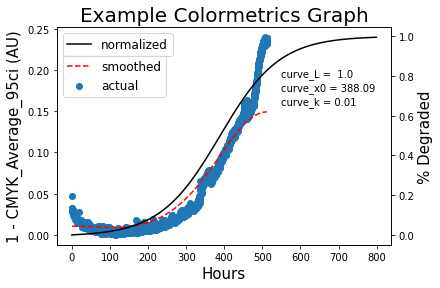

(array([1.00000000e+00, 3.88091882e+02, 1.27500166e-02]), 1.0000000001)

In [18]:
df = pd.read_csv(data_folder + 'b43_cmet.csv')
df = df.apply(lambda x: (x-np.min(x)) if x.name != 'Hour' else x) ## GETTING RID OF THE Y-INTERCEPT OFFSET TO IMPROVE FIT QUALITY
def get_curve_params(x,y):
    def logistic(x, L=1, x_0=0, k=1):
        return L / (1 + np.exp(-k * (x - x_0)))
    L_estimate = 0.6
    x_0_estimate = 200
    k_estimate = .03
    p_0 = [L_estimate, x_0_estimate, k_estimate]
    plt.scatter(x, y, label='actual')
    smoothed = gaussian_filter(y, sigma = 1000)
    plt.plot(x, smoothed,'--', label = 'smoothed', color='red')

    popt, _ = curve_fit(logistic, df['Hour'], smoothed, p_0, bounds = ([0, -np.inf, -np.inf],[1, np.inf, np.inf]))
    pred_cmet = logistic(range(800), *popt)
    pred_cmet = (pred_cmet-np.min(pred_cmet))/(popt[0]-np.min(pred_cmet))
    
    og_L = popt[0]
        
    p_0[2] = popt[2]
    p_0[1] = popt[1]
    p_0[0] = 1
    
    popt, _ = curve_fit(logistic, range(800), pred_cmet, p_0, bounds = ([1, popt[1]-1, 0],[1.0001, popt[1], popt[2]]))
    og_L = popt[0]
        
    p_0[2] = popt[2]
    p_0[1] = popt[1]
    p_0[0] = 1
    
    plt.ylabel('1 - CMYK_Average_95ci (AU)')
    plt.xlabel('Hours')
    plt.legend(loc='upper left',bbox_to_anchor=(0, 0.9), fontsize=12)

    plt2 = plt.gca().twinx()
    plt2.plot(range(800), pred_cmet, label = 'normalized', color = 'black')
    plt2.set_ylabel('% Degraded')
    plt2.legend(fontsize=12)


    plt.title('Example Colormetrics Graph')
    plt.rc('axes', titlesize=20)     # fontsize of the axes title
    plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
    plt.text(x = 550, y = 0.8, s = f"curve_L =  {round(popt[0], 2)}")
    plt.text(x = 550, y = 0.73, s = f"curve_x0 = {round(popt[1], 2)}")
    plt.text(x = 550, y = 0.66, s = f"curve_k = {round(popt[2], 2)}")
    plt.savefig('example_cmet_graph.png', dpi=300)
    plt.show()
    
    return popt, float(og_L)
get_curve_params(df['Hour'], df['sample0'])

In [ ]:
def get_curve_params(x,y):
    def logistic(x, L=1, x_0=0, k=1):
        return L / (1 + np.exp(-k * (x - x_0)))
    
    ############### COPY THE PARAMETERS HERE ################
    L_estimate = 0.6
    x_0_estimate = 200
    k_estimate = .03
    p_0 = [L_estimate, x_0_estimate, k_estimate]
    ##########################################################
    ############################################################
    ############################################################
    
    smoothed = gaussian_filter(y, sigma = 1000)


    popt, _ = curve_fit(logistic, x, smoothed, p_0, bounds = ([0, -np.inf, -np.inf],[1, np.inf, np.inf]))
    pred_cmet = logistic(range(800), *popt)
    pred_cmet = (pred_cmet-np.min(pred_cmet))/(popt[0]-np.min(pred_cmet))
    
    og_L = popt[0]
        
    p_0[2] = popt[2]
    p_0[1] = popt[1]
    p_0[0] = 1
    
    popt, _ = curve_fit(logistic, range(800), pred_cmet, p_0, bounds = ([1, popt[1]-1, 0],[1.0001, popt[1], popt[2]]))
    
    return popt, float(og_L)

def create_cmet_node(batch_id, sample_id, cmet, og_L, curve_L, curve_x0, curve_k):
    graph.run(f"""MATCH (n)
                  WHERE n.action = 'colormetrics' and n.batch_id = '{batch_id}' and n.sample_id = '{sample_id}'
                  DELETE n""")
    new_node = Node('Action', action = 'colormetrics', batch_id = batch_id, sample_id = sample_id, colormetrics_hours = [i[0] for i in cmet], \
                    normalized_colormetrics = [i[1] for i in cmet], curve_L = curve_L, curve_x0= curve_x0, curve_k = curve_k, original_L = og_L)
    
    graph.create(new_node)
    
def add_cmet_data(fp, b_id):
    cmet = pd.read_csv(fp)
    
    if 'Unnamed' in cmet.columns[0]:
        cmet = cmet.iloc[:,1:]

    for i in tqdm(cmet.columns[1:]):
        if i == 'Hour':
            continue
        cmet[i] = (cmet[i] - np.min(cmet[i]))
        curve_params, og_L = get_curve_params(cmet['Hour'], cmet[i])
        curve_params = [float(i) for i in curve_params]

        curr_cmet = cmet[['Hour', i]].values.tolist()
        curr_cmet = [[float(j) for j in i] for i in curr_cmet]
        create_cmet_node(b_id, i, curr_cmet, og_L, *curve_params)

## 4. Adding colormetric data to graphDB!
Execute the `add_cmet_data()` function with the appropriate filepath (name of your csv with the cmet data i.e. something like "b43_cmet.csv") and the corresponding `batch_id`

In [14]:
# add_cmet_data('b43_cmet.csv', 'somebatch_id') 

#### UNCOMMENT THE LINE ABOVE ONLY WHEN YOU ARE CERTAIN YOU WANT TO ADD THE DATA TO THE GRAPHDB! 